<a href="https://colab.research.google.com/github/Heffx/CNN/blob/master/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando o Pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  HTTP error 403 while getting http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [2]:
# Conferindo se o CUDA esta disponivel

verificaGPU = torch.cuda.is_available()

if not verificaGPU:
  print('CUDA INDISPONIVEL, TREINANDO COM CPU')
else:
  print('CUDA DISPONIVEL, TREINANDO COM GPU')

CUDA DISPONIVEL, TREINANDO COM GPU


In [3]:
# Instalando o Torch Vision
!pip3 install torchvision

In [4]:
# Instalando Pillow
!pip install Pillow==4.1.1

!pip install image

In [0]:
# Fazendo download e descompactando o dataset
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
# Todos os imports necessários'
import time
import json
import copy
import flower_data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from skimage import data, io, filters
from scipy.optimize import minimize
import cv2


In [0]:
# Definindo variavel global para treinamento com CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Carregando, Normalizando e Criando vetor de Imagens

In [0]:
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        # Redimensiona a imagem em (224,224)
        transforms.RandomResizedCrop(224),
        # Inverte horizontalmente a imagem
        transforms.RandomHorizontalFlip(),
        # Transforma em matriz de dados unicos
        transforms.ToTensor(),
        # Normaliza as imagens atraves de desvio padrão(Valores retirados de outro trabalho) 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        
        # Redimensiona a imagem em (224,224)
        #transforms.RandomResizedCrop(224),
        # Transformação da imagem para tamanho de entrada
         transforms.Resize(256),
        # Recorta a imagem no centro
         transforms.CenterCrop(224),
        # Transforma em matriz de dados unicos
        transforms.ToTensor(),
        # Normaliza as imagens atraves de desvio padrão(Valores retirados de outro trabalho) 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# print(data_transforms)

In [0]:
# Definindo nome dos diretorios de forma global para todo o código
train_dir = 'flower_data/train/'
valid_dir = 'flower_data/valid/'
dirs = {'train': train_dir, 
        'valid': valid_dir, 
       }

In [0]:
# Carregando as pastas do dataset
image_datasets = {x: datasets.ImageFolder(dirs[x],
                                          transform = data_transforms[x])
                  for x in ['train', 'valid']}

# Carregando imagens do dataset de treino e validação em  lotes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=32, shuffle=True) 
               for x in ['train', 'valid']}

# Carregando tamanho do dataset de treino e validação
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}

# Carregando as classes do dataset de treino
class_names = image_datasets['train'].classes

In [0]:
# print(dataset_sizes)
# print(device)

In [0]:
# Carregando arquivo Json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [13]:
# Atribuindo o nome das classes com o arquivo Json
images, labels = next(iter(dataloaders['train']))
images.size()
images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))

label: 90, class: 89, name: watercress


##Função de treino da rede

In [0]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25, device='cuda'):
    
    # Variável que calcula tempo gasto pelo modelo
    since = time.time()
    
    # Recebe os melhores parametros do modelo a cada iteração
    best_model_wts = copy.deepcopy(model.state_dict())
    # Variável que calcula melhor acurácia
    best_acc = 0.0
    
    # FOR que roda todas as iterações
    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treinamento e validação
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Definir modelo para o modo de treinamento
            else:
                model.eval()   # Definir modelo para avaliar o modo
            
            # Várivel que recebe os erros da rede
            running_loss = 0.0
            # Várivel que recebe os acertos da rede
            running_corrects = 0

            # Carregando os bancos de dados.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zerando os gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward
                # Set histórico somente no treinamento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize somente na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        
                # Estátisticas
                # A cada erro da rede o valor e armazenado na váriavel running_loss
                running_loss += loss.item() * inputs.size(0)
             
                # A cada acerto da rede o valor e armazenado na váriavel running_corrects
                running_corrects += torch.sum(preds == labels.data)

            # Cálculo do valor de erros a cada iteração de epóca
            epoch_loss = running_loss / dataset_sizes[phase]
            # Cálculo do valor da acurácia a cada iteração de epóca
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Printa na tela o valor de erros e da acuracia no treino e na validação
            print('{} Loss: {:.4f} Acurácia: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Armazena dados da rede na fase de validação
            if phase == 'valid' and epoch_acc > best_acc:
                # Armazena a época que que a rede teve melhor valor de acurácia 
                best_acc = epoch_acc
                # Armazena os parametros para próxima iteração da rede
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    # Variavel que recebe o valor total do tempo gasto pelo modelo
    time_elapsed = time.time() - since
    print('Treino completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # Printa na tela o maior de valor acurácia
    print('Melhor Acurácia: {:4f}'.format(best_acc))

    # Carrega os parametros da rede
    model.load_state_dict(best_model_wts)
    
    # Retorna o modelo
    return model

## Pré-treino VGG 19

In [0]:
# Carregando em model a rede VGG19
model = models.vgg19(pretrained=True)

In [16]:
# Verificando se o modelo foi carregado corretamente
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:

#Definindo a arquitetura da rede
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(25088,4096)
    self.fc2 = nn.Linear(4096,102)
    
  def forward(self,x):
    # Verifica se o tensor está "flattened (achatado)"
    x = x.view(x.shape[0],-1)
    
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x),dim=1)
    
    return x


In [0]:
classifier = Classifier()
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = classifier

In [0]:
if verificaGPU:
    model.cuda()

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optim = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optim, step_size=4, gamma=0.1)
# Number of epochs
eps=50

##Treinando a rede com o modelo VGG

In [21]:
 model_ft = train_model(model, criterion, optim, sched, eps, 'cuda')

Época 0/2
----------
train Loss: 2.2920 Acurácia: 0.5116
valid Loss: 0.7348 Acurácia: 0.7824

Época 1/2
----------
train Loss: 0.9971 Acurácia: 0.7241
valid Loss: 0.6285 Acurácia: 0.8301

Época 2/2
----------
train Loss: 0.8275 Acurácia: 0.7718
valid Loss: 0.6323 Acurácia: 0.8313

Treino completo em 12m 33s
Melhor Acurácia: 0.831296


## Salvando modelo

In [0]:
# Salvando Modelo
torch.save(model.state_dict(), './vgg19.pth')

## Pré-treino AlexNet

In [0]:
#model_alex = models.alexnet(pretrained=True)

In [0]:
#classifier = model_alex.classifier[1].in_features

In [0]:
#if verificaGPU:
#    model_alex.cuda()

In [0]:
#model_alex.to(device)

In [0]:
#optim_alex = torch.optim.Adam(params = model_alex.parameters(), lr=0.001)

In [0]:
#criterion_alex = nn.CrossEntropyLoss()

#sched_alex = lr_scheduler.StepLR(optim_alex, step_size=4, gamma=0.1)

## Treinando a rede com o modelo AlexNet

In [0]:
#model_ft = train_model(model_alex, criterion_alex, optim_alex, sched_alex, eps, 'cuda')

## Salvando Modelo

In [0]:
# Salvando Modelo
#torch.save(model_alex.state_dict(), './alexnet.pth')

model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')

## Predição 

In [0]:
# Processa a imagem como no modelo
def process_image(image_path):
    
    # Abrindo a imagem
    img = Image.open(image_path)
    
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move os canais de cor para a primeira dimensão conforme esperado pelo PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
# Função que recebe a imagem, o modelo, e o numero de classes vc quer que ele apresente.
def predict(image_path, model, top_num=5):
   
    # Processa a imagem com a função acima
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Muda o lote para tamanho 1
    model_input = image_tensor.unsqueeze(0)
    # Testa a probabilidade com o modelo
    probs = torch.exp(model.forward(model_input))
    # Recebe os principais modelos retornados pela rede
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    # converte os indices recebidos no nome das classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    
    # Retorno para a função de plot
    return top_probs, top_labels, top_flowers

In [0]:
# Função de plotar resultado da predição
def plot_solution(image_path, model):
    # Set plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set titulo
    #Carrega o numero da classe da flor
    flower_num = image_path.split('/')[2]
    # Carrega o nome da classe de acordo com o numero obtido acima
    title_ = cat_to_name[flower_num]
    # Plot flor
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Recendo previsão da função acima
    probs, labs, flowers = predict(image_path, model) 
    # Plot gráfico de barras
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


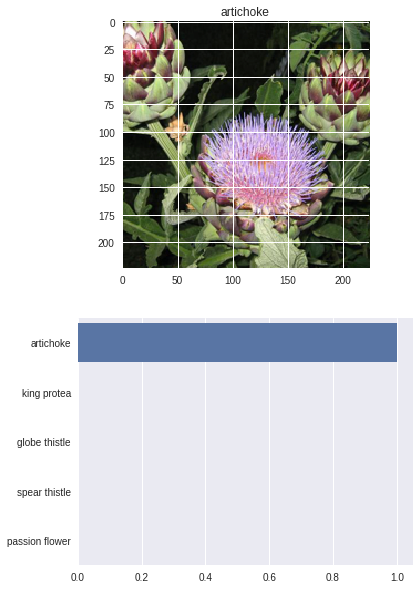

In [122]:
image_path = 'flower_data/valid/29/image_04143.jpg'
plot_solution(image_path, model)